<a href="https://colab.research.google.com/github/Abhishek672/cs6910_Assignment2/blob/main/partA/CNN_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from PIL import Image 
import random
import numpy as np
import pickle
import random
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

from keras import backend as k
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator ,img_to_array
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,AveragePooling2D,Dropout,BatchNormalization,Activation
from keras.activations import relu,softmax
from keras.initializers import he_normal,glorot_normal,random_normal,glorot_uniform
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta,Adam
from keras.utils import np_utils
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
! wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip


--2021-04-13 21:14:40--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G  19.0MB/s    in 66s     

2021-04-13 21:15:46 (55.1 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [ ]:
! unzip '/content/nature_12K.zip'

**0.Visualizing some train samples**

In [4]:
def plot_sample_images(train_path):

  train_gen = ImageDataGenerator().flow_from_directory(
      directory = train_path,
      color_mode = 'rgb',
      class_mode = 'categorical'
  )

  cls = train_gen.classes
  dict1 = train_gen.class_indices
  idx_to_class = {v:k for k,v in dict1.items()}
  paths = train_gen.filepaths
  tot_images = len(paths)
  sampled_class = [0]*10
  count =0
  
  ix = 1 
  plt.figure(figsize = (15,8))
  while count!=10:
    i = random.randrange(0,tot_images+1)
    cls_i = cls[i]

    if sampled_class[cls_i]==0:
      img = load_img(paths[i] ,target_size = (256,256))
      ax = plt.subplot(2,5,ix)
      ax.set_xticks([]);ax.set_yticks([]);ax.set_title(idx_to_class[cls_i])
      plt.imshow(img)
      ix+=1
      sampled_class[cls_i] = 1
      count+=1

  plt.suptitle('sample images from train.')  
  plt.show()
  return


Found 9999 images belonging to 10 classes.


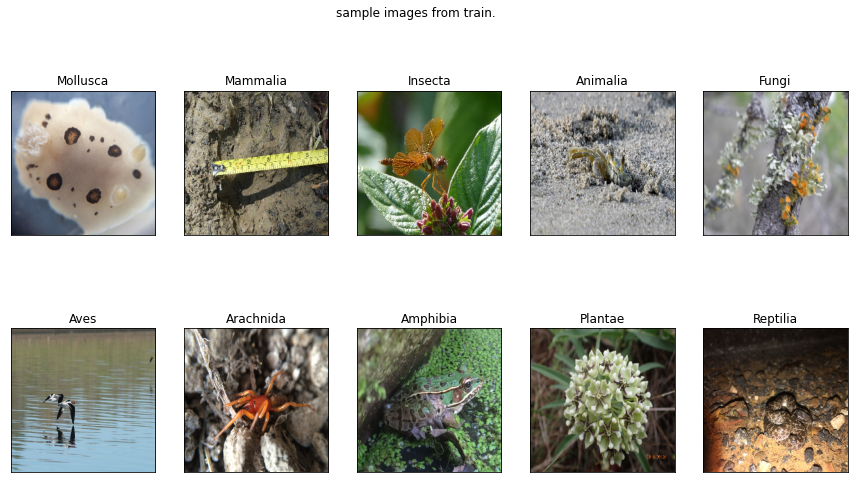

In [5]:
train_path = '/content/inaturalist_12K/train'
plot_sample_images(train_path)

**Q.2. Hyperparameter tuning on 10% of Data**

In [12]:
class CNN_M:

  def __init__(self,input_shape,target_size ,num_filters,filter_size,fo,num_neurons,data_aug,dropout,BN,num_outputs):
    self.model = Sequential()
    self.input_shape = input_shape
    self.target_size = target_size
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.fo = fo
    self.num_neurons =num_neurons
    self.data_aug = data_aug
    self.dropout = dropout
    self.BN = BN
    self.num_outputs = num_outputs

  def BUILD_MODEL(self):
    
    #Build 1st layer...
    self.model.add(Conv2D(filters = self.num_filters ,kernel_size =self.filter_size,use_bias = True,
                          input_shape=self.input_shape))
    self.model.add(Activation('relu'))
    self.model.add(MaxPooling2D(pool_size=(2,2)))

    cf = self.num_filters 
    for i in range(1,5):
      cf*=self.fo
      self.model.add(Conv2D(filters = cf , kernel_size = self.filter_size ,use_bias= True))
      if self.BN == 'Yes':
        self.model.add(BatchNormalization(axis = -1))

      self.model.add(Activation('relu'))
      self.model.add(Dropout(self.dropout))
      self.model.add(MaxPooling2D(pool_size=(2,2)))

    self.model.add(Flatten())
    self.model.add(Dense(units=self.num_neurons))
    
    if self.BN == 'Yes':
      self.model.add(BatchNormalization(axis = -1))
    
    self.model.add(Activation('relu'))
    self.model.add(Dropout(self.dropout))

    self.model.add(Dense(units = self.num_outputs ,activation='softmax'))

    self.model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return 


  #Fit model using the train datagenerator and returns fitted model..
  def fit_CNN(self , train_path ,epochs ,batch_size):

    if self.data_aug == 1:
      tr_datagen = ImageDataGenerator(rescale=1./255,validation_split = 0.1,
                                      zoom_range=0.2 ,horizontal_flip=True ,rotation_range=30 ,shear_range=12)
    else:
      tr_datagen = ImageDataGenerator(rescale=1./255,
                             validation_split = 0.1)
    
    tr_gen = tr_datagen.flow_from_directory(
        directory = train_path,target_size = self.target_size,color_mode = 'rgb',       
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True,
        seed = 10,
        subset = 'training'
        )

    val_gen = tr_datagen.flow_from_directory(
        directory = train_path,target_size = self.target_size,color_mode = 'rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True,
        seed = 10,
        subset = 'validation'
        ) 
      
    #Fitting The model...
    step_size_train = tr_gen.n//tr_gen.batch_size
    step_size_valid = val_gen.n//val_gen.batch_size

    self.model.fit_generator(generator = tr_gen,
                             steps_per_epoch = step_size_train,
                             validation_data = val_gen,
                             validation_steps = step_size_valid,
                             epochs = epochs, verbose=1,
                            callbacks = [WandbCallback(monitor='val_accuracy',
                                                    save_model = True),
                                          EarlyStopping(monitor='val_loss',min_delta = 0.05,patience=3)])
    return 

In [7]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 2.1MB 4.5MB/s 
     |████████████████████████████████| 102kB 7.0MB/s 
     |████████████████████████████████| 133kB 17.2MB/s 
     |████████████████████████████████| 163kB 17.2MB/s 
     |████████████████████████████████| 71kB 5.4MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
import wandb
from wandb.keras import WandbCallback

In [9]:
sweep_config = {
  'name': 'A2.QA',
  'method': 'grid',
  'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
  'parameters': {
        'num_filters': {
            'values': [64,32]
        },
        'fo':{
            'values':[2,1,0.5]
        },
        'data_aug':{
            'values':[1,0]
        },
        'dropout':{
            'values':[0.3,0.2]
        },
        'BN':{
            'values':['No','Yes']
        }

    }
}

sweep_id = wandb.sweep(sweep_config, project='CNN_PartA', entity='manideepladi')

Create sweep with ID: 1azxrtc1
Sweep URL: https://wandb.ai/manideepladi/CNN_PartA/sweeps/1azxrtc1


In [10]:
def train():
  run = wandb.init()
  configuration=run.config

  target_size = (224,224)
  if k.image_data_format()=='channels_first':
    input_shape = (3,224,224)

  else:
    input_shape = (224,224,3)

  train_path = '/content/inaturalist_12K/train'

  epochs =20
  batch_size =64
  cnn = CNN_M(input_shape = input_shape,
            target_size = target_size,
            num_filters = configuration.num_filters,
            filter_size =3,
            fo = configuration.fo,
            num_neurons = 64,
            data_aug = configuration.data_aug,
            dropout = configuration.dropout,
            BN = configuration.BN,
            num_outputs = 10)
  
  cnn.BUILD_MODEL()
  cnn.fit_CNN(train_path,epochs=epochs,batch_size=batch_size)

#train()
sweep_id="434a1r4x"
wandb.agent(sweep_id=sweep_id, function=train)

wandb: Agent Starting Run: eww4tkqj with config:
wandb: 	BN: Yes
wandb: 	data_aug: 0
wandb: 	dropout: 0.2
wandb: 	fo: 1
wandb: 	num_filters: 32
wandb: Currently logged in as: manideepladi (use `wandb login --relogin` to force relogin)


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/20
140/140 [==============================] - 768s 5s/step - loss: 2.3274 - accuracy: 0.1878 - val_loss: 2.4850 - val_accuracy: 0.1031
Epoch 2/20
140/140 [==============================] - 760s 5s/step - loss: 1.9872 - accuracy: 0.2937 - val_loss: 2.5806 - val_accuracy: 0.1021
Epoch 3/20
140/140 [==============================] - 762s 5s/step - loss: 1.9029 - accuracy: 0.3320 - val_loss: 2.6333 - val_accuracy: 0.1146
Epoch 4/20
140/140 [==============================] - 759s 5s/step - loss: 1.8561 - accuracy: 0.3502 - val_loss: 2.3941 - val_accuracy: 0.1437
Epoch 5/20
140/140 [==============================] - 758s 5s/step - loss: 1.8037 - accuracy: 0.3680 - val_loss: 2.2710 - val_accuracy: 0.1802
Epoch 6/20
140/140 [==============================] - 756s 5s/step - loss: 1.7396 - accuracy: 0.3885 - val_loss: 2.2262 - val_accuracy: 0.1906
Epoch 7/20
140/140 [==============================] - 754

wandb: Agent Starting Run: k4ty0tci with config:
wandb: 	BN: Yes
wandb: 	data_aug: 0
wandb: 	dropout: 0.2
wandb: 	fo: 0.5
wandb: 	num_filters: 64


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/20
140/140 [==============================] - 1088s 8s/step - loss: 2.4635 - accuracy: 0.1454 - val_loss: 2.4729 - val_accuracy: 0.0969
Epoch 2/20
140/140 [==============================] - 1074s 8s/step - loss: 2.1612 - accuracy: 0.2196 - val_loss: 2.3581 - val_accuracy: 0.1281
Epoch 3/20
140/140 [==============================] - 1075s 8s/step - loss: 2.1037 - accuracy: 0.2368 - val_loss: 2.2337 - val_accuracy: 0.1885
Epoch 4/20
140/140 [==============================] - 1081s 8s/step - loss: 2.0595 - accuracy: 0.2607 - val_loss: 2.1606 - val_accuracy: 0.2177
Epoch 5/20
140/140 [==============================] - 1061s 8s/step - loss: 2.0027 - accuracy: 0.2871 - val_loss: 2.2054 - val_accuracy: 0.1750
Epoch 6/20
140/140 [==============================] - 1079s 8s/step - loss: 1.9891 - accuracy: 0.2928 - val_loss: 2.1215 - val_accuracy: 0.2406
Epoch 7/20
140/140 [==============================]

wandb: Agent Starting Run: 092mn9wm with config:
wandb: 	BN: Yes
wandb: 	data_aug: 0
wandb: 	dropout: 0.2
wandb: 	fo: 0.5
wandb: 	num_filters: 32


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/20
140/140 [==============================] - 609s 4s/step - loss: 2.5237 - accuracy: 0.1101 - val_loss: 2.3964 - val_accuracy: 0.0875
Epoch 2/20
140/140 [==============================] - 603s 4s/step - loss: 2.2697 - accuracy: 0.1656 - val_loss: 2.3103 - val_accuracy: 0.0979
Epoch 3/20
140/140 [==============================] - 604s 4s/step - loss: 2.1818 - accuracy: 0.1958 - val_loss: 2.2793 - val_accuracy: 0.1490
Epoch 4/20
140/140 [==============================] - 603s 4s/step - loss: 2.1385 - accuracy: 0.2211 - val_loss: 2.1933 - val_accuracy: 0.1917
Epoch 5/20
140/140 [==============================] - 604s 4s/step - loss: 2.1315 - accuracy: 0.2205 - val_loss: 2.4302 - val_accuracy: 0.1177
Epoch 6/20
140/140 [==============================] - 607s 4s/step - loss: 2.1239 - accuracy: 0.2184 - val_loss: 2.2540 - val_accuracy: 0.1542
Epoch 7/20
140/140 [==============================] - 607

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [13]:
target_size = (224,224)
if k.image_data_format()=='channels_first':
  input_shape = (3,224,224)

else:
  input_shape = (224,224,3)

train_path = '/content/inaturalist_12K/train'

epochs =20
batch_size =64
cnn = CNN_M(input_shape = input_shape,
            target_size = target_size,
            num_filters = 64,
            filter_size =3,
            fo = 1,
            num_neurons = 64,
            data_aug = 0,
            dropout = 0.2,
            BN = 'No',
            num_outputs = 10)
  
cnn.BUILD_MODEL()
cnn.fit_CNN(train_path,epochs=epochs,batch_size=batch_size)

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/20
140/140 [==============================] - 111s 790ms/step - loss: 2.2963 - accuracy: 0.1148 - val_loss: 2.2431 - val_accuracy: 0.1688
Epoch 2/20
140/140 [==============================] - 111s 789ms/step - loss: 2.2124 - accuracy: 0.1735 - val_loss: 2.1913 - val_accuracy: 0.2177
Epoch 3/20
140/140 [==============================] - 109s 781ms/step - loss: 2.1316 - accuracy: 0.2259 - val_loss: 2.1581 - val_accuracy: 0.2229
Epoch 4/20
140/140 [==============================] - 109s 778ms/step - loss: 2.0737 - accuracy: 0.2571 - val_loss: 2.0827 - val_accuracy: 0.2875
Epoch 5/20
140/140 [==============================] - 109s 779ms/step - loss: 1.9953 - accuracy: 0.2890 - val_loss: 2.0467 - val_accuracy: 0.2906
Epoch 6/20
140/140 [==============================] - 109s 777ms/step - loss: 1.9267 - accuracy: 0.3132 - val_loss: 2.0392 - val_accuracy: 0.2844
Epoch 7/20
140/140 [===================

In [ ]:
cnn.model.summary()

**Q3.Based on the above plots write down some insightful observations.**

  Inferences can be found in report

**Q.4.You will now apply your best model on the test data (You shouldn't have used test data so far. All the above experiments should have been done using train and val data only).**

In [ ]:
# cnn.model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

# #returns a compiled model
# #identical to the previous one
# model = load_model('my_model.h5')

In [15]:
#Return the accuracy and predictions on test data ..

test_path = '/content/inaturalist_12K/val'
ts_datagen = ImageDataGenerator(rescale = 1./255)
test_gen = ts_datagen.flow_from_directory(
    directory = test_path,
    target_size = (224,224),
    color_mode = 'rgb',
    batch_size = 1,
    class_mode = None,
    shuffle = False,
    seed=10
    )
    
step_size_test = test_gen.n//test_gen.batch_size
test_gen.reset()

pred = cnn.model.predict_generator(generator = test_gen,
                                  steps = step_size_test,
                                  verbose = 1
                                  )
    
ypred = np.argmax(pred,axis=1)
ytrue = test_gen.classes 


Found 2000 images belonging to 10 classes.
2000/2000 [==============================] - 27s 13ms/step


**Q.4.a use the best model and report accuracy on test data**

In [16]:
print("Test accuracy", np.sum(ypred == ytrue)/len(ytrue))

Test accuracy 0.3475


**Q.4.b.Provide a 10 x 3 grid containing sample images from the test data and predictions made by your best model (more marks for presenting this grid creatively).**

In [17]:
dict1 = test_gen.class_indices
idx_to_class = {v:k for k,v in dict1.items()}

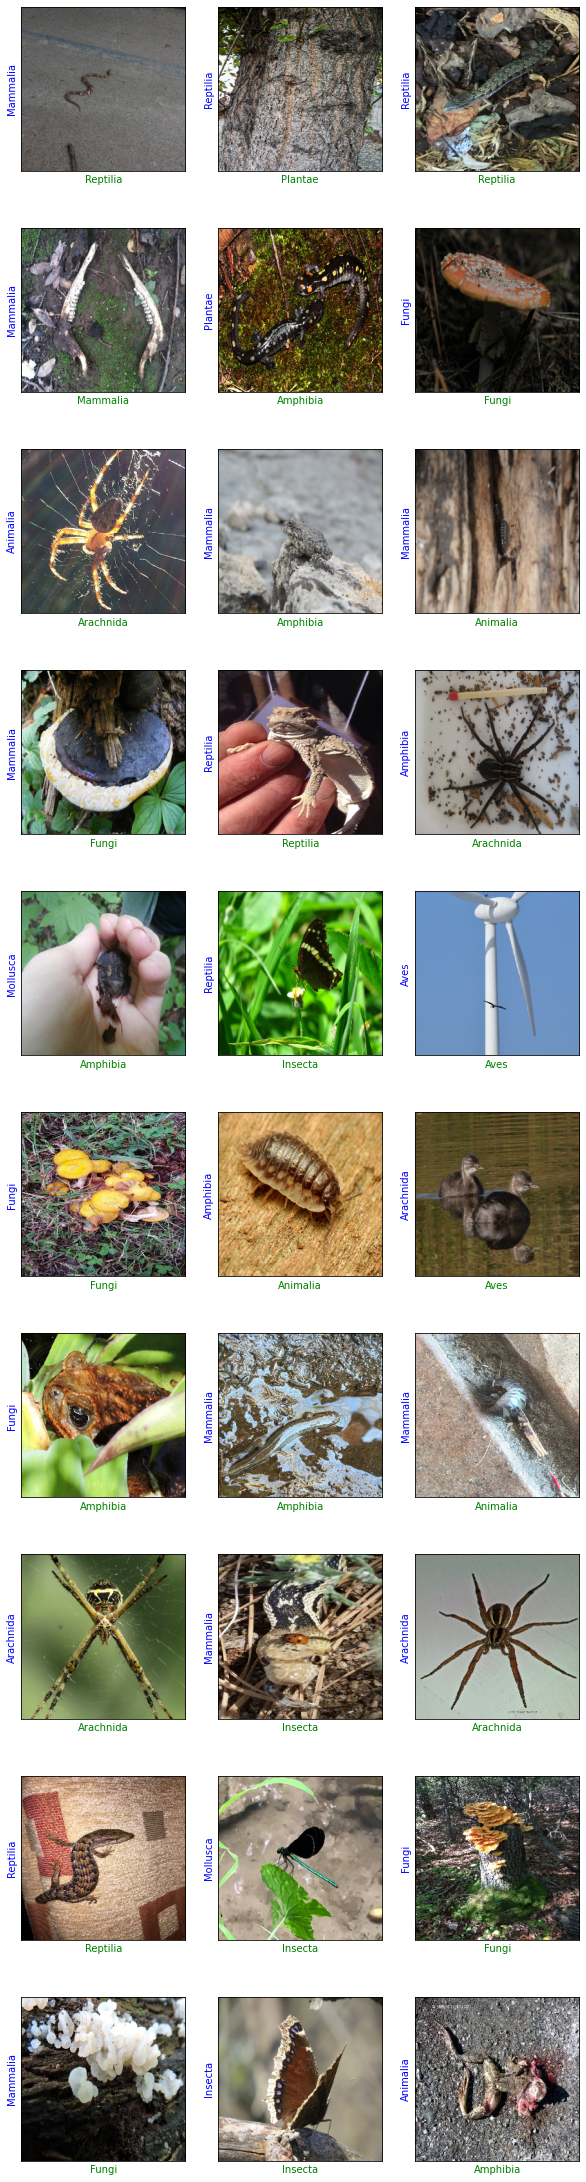

In [19]:
from keras.preprocessing.image import load_img

random.seed(10)
test_image_paths = test_gen.filepaths
rnd_idx = np.random.choice(len(test_image_paths),30,replace=False)
ix=1
plt.figure(figsize=(10,40))
for idx in rnd_idx:
  ax = plt.subplot(10,3,ix)
  img = load_img(test_image_paths[idx],target_size=(256,256))
  ax.set_xticks([])
  ax.set_yticks([])
  true_label = idx_to_class[ytrue[idx]]
  pred_label = idx_to_class[ypred[idx]]

  ax.set_xlabel(true_label);ax.xaxis.label.set_color('green')
  ax.set_ylabel(pred_label);ax.yaxis.label.set_color('blue')

  plt.imshow(img)

  ix+=1
plt.show()


**Q4.c.Visualise all the filters in the first layer of your best model for a random image from the test set. If there are 64 filters in the first layer plot them in an 8 x 8 grid.**

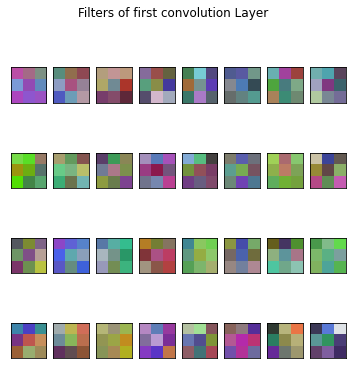

In [20]:
filters , biases = cnn.model.layers[0].get_weights()
f_min , f_max = filters.min() , filters.max()

filters = (filters - f_min)/(f_max - f_min)
n_filters ,ix = 32 ,1
#4x8 grid
plt.figure(figsize = (6,6))
for i in range(n_filters):
   f = filters[:,:,:,i]
   ax = plt.subplot(4,8,ix)
   ax.set_xticks([])
   ax.set_yticks([])
   plt.imshow(f)
   ix+=1

plt.suptitle("Filters of first convolution Layer")
plt.show()

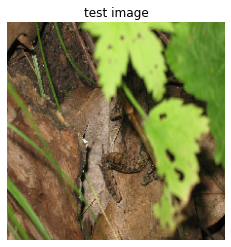

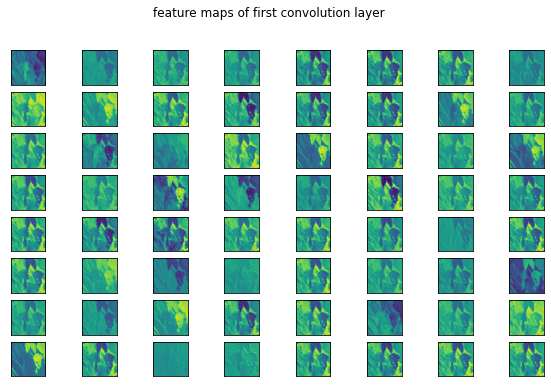

In [21]:
#feature Map for first convolution layer..
output_layer1 = cnn.model.layers[0].output
fmodel = Model(inputs = cnn.model.inputs , outputs = output_layer1)

ts_img = load_img(test_image_paths[189],target_size=(224,224))
plt.imshow(ts_img)
plt.axis('off')
plt.title('test image')
ip_img = img_to_array(ts_img)
ip_img = ip_img.reshape((1,)+ip_img.shape)
ip_img/=255.0

fmaps = fmodel.predict(ip_img)
num_fmaps = fmaps.shape[3]
ix = 1
plt.figure(figsize = (10,6))
for i in range(num_fmaps):

   ax = plt.subplot(8,8,ix)
   ax.set_xticks([])
   ax.set_yticks([])
   plt.imshow(fmaps[0,:,:,ix-1])
   ix+=1

plt.suptitle("feature maps of first convolution layer")
plt.show()

Question 5 (10 Marks)
Apply guided back propagation on any 10 neurons in the CONV5 layer and plot the images which excite this neuron. The idea again is to discover interesting patterns which excite some neurons. You will draw a 10 x 1 grid below with one image for each of the 10 neurons.

In [22]:
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad


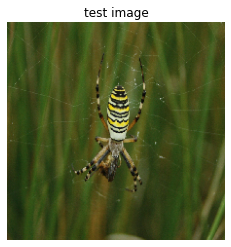

In [23]:
ts_img = load_img(test_image_paths[567],target_size=(224,224))
plt.imshow(ts_img)
plt.axis('off')
plt.title('test image')
ip_img = img_to_array(ts_img)
ip_img = ip_img.reshape((1,)+ip_img.shape)
ip_img/=255.0

In [24]:
def deprocess_image(x):
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + k.epsilon())
    x *= 0.25
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    if k.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

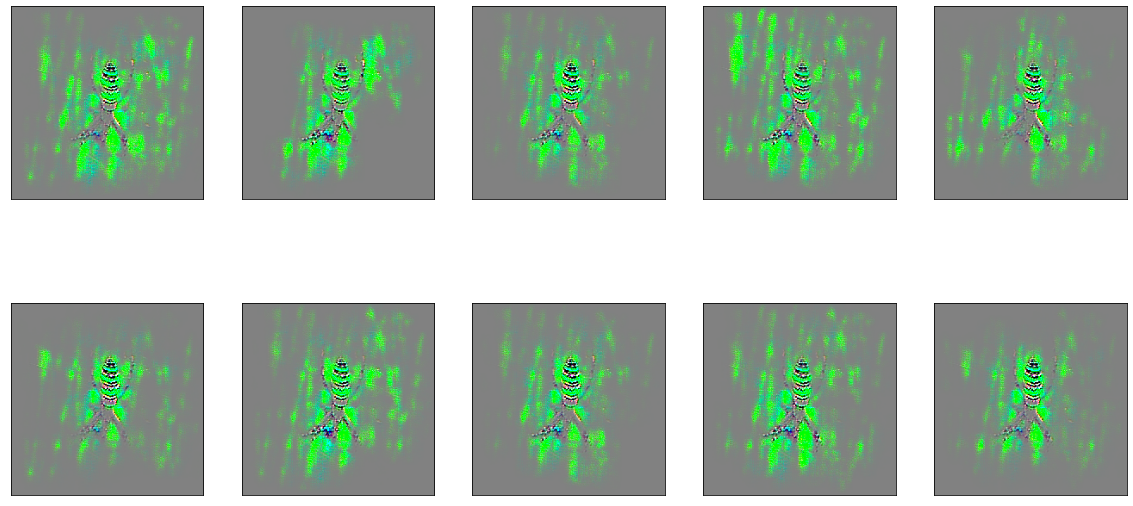

In [30]:
import random
fig = plt.figure(figsize=(20, 10))
ix=1
for i in range(10,20):
  neuronNo=random.randint(0,63)
  output_layer1 = cnn.model.layers[20].output[:,neuronNo]
  gb_model=Model(inputs = cnn.model.inputs , outputs = output_layer1)
  layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
  for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
      layer.activation = guidedRelu

  with tf.GradientTape() as tape:
    inputs = tf.cast(ip_img, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)
  grads = tape.gradient(outputs,inputs)[0]
  ax = fig.add_subplot(2,5,ix)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))
  ix=ix+1
